<img src="./images/Logos.jpg" title="Institutional Logos" width="70%">


# Heat Waves | Scenario 03: Integration Test of CLIMADA Impact Assessment with Copernicus Climate Change Service (C3S) data (V1)

### About

Welcome to this **03 Scenario** tutorial, which guides you through analysing heat stress impacts using CLIMADA in the context of the U-CLIMADAPT project (User-centric Assessment of Climate Change Impacts for Adaptation). This tutorial is part of a series of four, focusing on **01 Installation and Data Access**, **02 Warm-up**, **03 Scenario**, and **04 Uncertainty and Sensitivity**. Tutorials 02 to 04 are independent but require you to first complete 01 Installation and Data Access before running each script.

In earlier tutorials, you learned how to access and download climate data from Copernicus, process it, and integrate it into impact assessments using CLIMADA. This tutorial shifts the focus to climate change scenarios. You'll explore how different climate pathways, like RCP 8.5, influence heatwave trends and learn to estimate future impacts on populations under this scenario. Step by step, this guide will help you set up and analyse scenario-based data to assess how projected heatwaves will shape risk and vulnerability over time.

## About U-CLIMADAPT

The U-CLIMADAPT project is a collaborative effort led by the Working Group "Impact of Climate Change." Its primary goal is to provide refined climate impact assessments tailored to specific requirements. To achieve this, it leverages the power of climate forecasts and projections from C3S's Climate Data Store (CDS) while also integrating Copernicus land-use and satellite data.

## About CLIMADA 

CLIMADA (CLIMate ADAptation) is an open-source Python-based platform developed by the Weather and Climate Risk group at ETH Zurich. It is designed to quantify the risks and impacts of climate change and to support adaptation strategies. CLIMADA combines probabilistic hazard modelling, exposure data, and vulnerability/impact functions to assess the impacts of hazards. 

Here is an overview of the core components of CLIMADA. For more information, please visit the [**CLIMADA documentation**](https://climada-python.readthedocs.io/en/stable/index.html):

- [Hazard](https://climada-python.readthedocs.io/en/stable/tutorial/1_main_climada.html#hazard): Models the probability and intensity of climate-related events.
- [Exposure](https://climada-python.readthedocs.io/en/stable/tutorial/exposures.html): Represents the spatial distribution of people, ecosystems, infrastructure, and/or economic assets at risk.
- [Vulnerability](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_ImpactFuncSet.html#): Measures how susceptible the exposed elements are to damage.
- [Impact](https://climada-python.readthedocs.io/en/stable/tutorial/impact.html#): Combines hazard, exposure, and vulnerability data to calculate potential damages and losses.
- Adaptation: Assesses the effectiveness of mitigation strategies to reduce risks and losses

## Integrating CLIMADA and Copernicus Data

U-CLIMADAPT integrates Copernicus Climate Data Store (CDS) datasets with CLIMADA to create a powerful tool for assessing the socioeconomic impacts of climate hazards. By combining Copernicus data on extreme heat, floods, drought, and more with CLIMADA’s modelling capabilities, users can estimate risks to populations, infrastructure, and assets, enabling data-driven climate adaptation strategies.

## Tutorial Overview

Now, let's dive into the tutorial itself. We will guide you through the following steps:

- Search, download, and visualize climate scenario data from the Climate Data Store.
- Set up the heatwave hazard, focusing on different climate scenarios like RCP 8.5.
- Estimate the population exposure to future heatwaves in the study area.
- Define vulnerability and calculate the potential impacts of heatwaves over time.
- Visualize and interpret the results to understand how exposure and impacts evolve under different climate scenarios.

By following this tutorial, you will gain hands-on experience and unlock the potential of integrating CLIMADA with C3S data from Copernicus. Let's get started!

<br>

## Acknowledgments

- **Script Author**: [Dahyann Araya](https://github.com/DahyannAraya?tab=repositories)
- **Reviewer**: [Tat Chi Wong](https://github.com/wongtaeth), [Ruth Lorenz](https://github.com/ruthlorenz)

## Import libraries

We will be working with data in NetCDF format. To best handle this data, we will use libraries for working with multidimensional arrays, particularly Xarray. We will also need libraries for plotting and viewing data; in this case, we will use Matplotlib and Cartopy.

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays and data manipulation
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for geospatial data processing
import geopandas as gpd
import rasterio
import rasterio.mask
import fiona

# Libraries for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Utilities
import os
import zipfile
import warnings

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()
warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely.predicates")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely.constructive")

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [2]:
DATADIR = "/Users/daraya/Documents/test_data" # create a file to save the data
os.makedirs(DATADIR, exist_ok=True)

In [3]:
#import os
#from climada import CONFIG
#DATADIR = str(CONFIG.data_dir)
#os.mkdir(DATADIR, exist_ok=True)
#os.makedirs(DATADIR, exist_ok=True)

In [4]:
current_directory = os.getcwd()

# Print the current directory
print("Current Directory:", current_directory)

Current Directory: /Users/daraya/Documents/GitHub_files/CDS_Warm_up/CDS_Warm_Up


# Set a heat wave hazard 

In this first exercise, our goal is to analyze the heatwave hazard in Europe using the [heatwave days dataset from Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview). The dataset provides information for different future periods and considers climate change scenarios, specifically RCP 8.5.

A bias-adjusted EURO-CORDEX dataset offers temperature data from 1971 to 2100. By averaging the statistics over 30-year intervals, a smoothed mean time series spanning 1986 to 2085 is obtained. The dataset provides annual heatwaves days data with a resolution of 0.1° in latitude and longitude, equivalent to approximately 11 kilometers at the equator.

By conducting this exercise, we aim to gain insights into the long-term heatwave trends in Europe, considering future projections and climate change scenarios. This analysis can contribute to a better understanding of the potential impacts of heatwaves on the region and inform relevant mitigation and adaptation strategies.

## Inspect data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [5]:
# Define the data directory and file path
DATADIR = os.path.join(os.path.expanduser("~/Documents"), "test_data")
zip_file = f"{DATADIR}/sis-heat-and-cold-spells.tar.gz"  # Actually a ZIP file

# Check if the file is a valid ZIP file and extract its contents
if zipfile.is_zipfile(zip_file):
    with zipfile.ZipFile(zip_file, "r") as file:
        # Print the names of the files in the ZIP archive
        print(file.namelist())
        # Extract all files into the DATADIR
        file.extractall(DATADIR)
else:
    print(f"The file at {zip_file} is not a valid ZIP file.")

['HWD_EU_health_rcp85_mean_v1.0.nc']


In [6]:
hwd_eu_rcp85_mean = f'{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc'
ds = xr.open_dataset(hwd_eu_rcp85_mean)
ds

<xarray.Dataset> Size: 102MB
Dimensions:        (lat: 425, lon: 599, time: 100)
Coordinates:
    height         float64 8B ...
  * lat            (lat) float64 3kB 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon            (lon) float64 5kB -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time           (time) datetime64[ns] 800B 1986-01-01 ... 2085-01-01
Data variables:
    HWD_EU_health  (time, lat, lon) float32 102MB ...
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 12:30:06 2019
    institution:    VITO (https://vito.be/en)

In [7]:
hwd_eu_rcp85_mean = ds['HWD_EU_health'] # Extract variable

In [8]:
# Shape and sizes
print(hwd_eu_rcp85_mean.shape)
print(hwd_eu_rcp85_mean.size)

(100, 425, 599)
25457500


See below what the annual heatwave days look like in 2010 and 2080. We can see that under this RCP8.5 scenario, heatwave days increased from 18 days per year in 2010 in the territory under study to a maximum of 80 days in 2080.

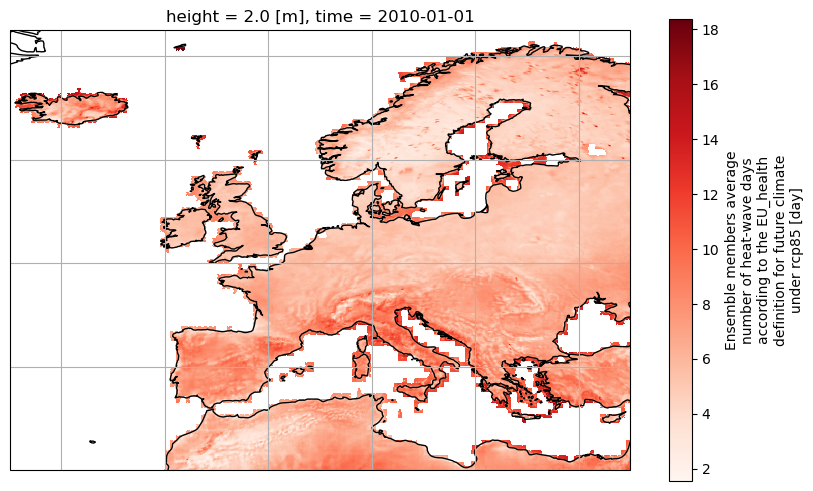

In [9]:
import cartopy.crs as ccrs

# Heat waves days in 2010
# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': proj})

# Plot the data isel() method. Here time=98 retrieves data corresponding to the 24th time step
hwd_eu_rcp85_mean.isel(time=24).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
plt.show()

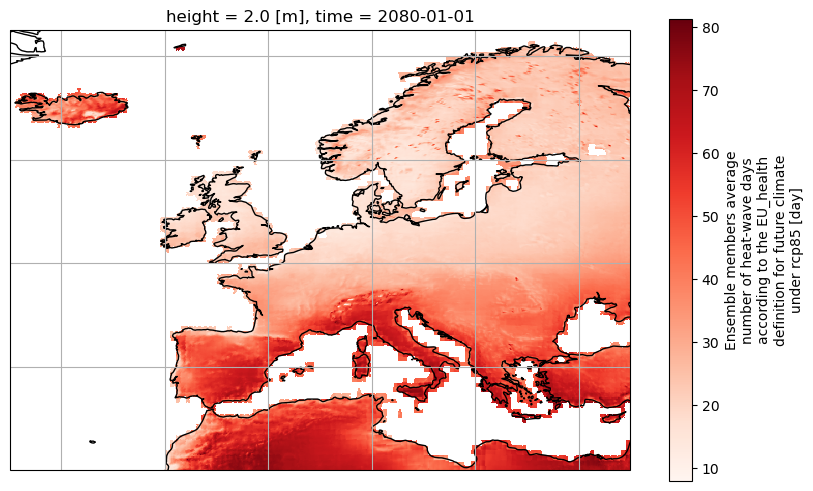

In [10]:
# Heat waves days in 2080

# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': proj})

# Plot the data isel() method 
hwd_eu_rcp85_mean.isel(time=94).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

In [11]:
# Average number of heatwave days in the area, measured every 10 years from 2010 to 2080
years_range = range(2010, 2081, 10)

# Dictionary to hold the average heatwave days for each year
average_heatwave_days = {}

for year in years_range:
    # Filter the dataset for the specific year
    ds_filtered = ds.sel(time=str(year))
    mean_heatwave_days = ds_filtered['HWD_EU_health'].mean().values
    average_heatwave_days[year] = mean_heatwave_days

# Print the average heatwave days per year for all the area
for year, avg_days in average_heatwave_days.items():
    print(f"Year: {year}, Average Heatwave Days: {avg_days:.2f}")

Year: 2010, Average Heatwave Days: 6.33
Year: 2020, Average Heatwave Days: 8.27
Year: 2030, Average Heatwave Days: 10.49
Year: 2040, Average Heatwave Days: 13.70
Year: 2050, Average Heatwave Days: 18.13
Year: 2060, Average Heatwave Days: 23.46
Year: 2070, Average Heatwave Days: 29.50
Year: 2080, Average Heatwave Days: 35.73


# Heat waves impact scenarios

In this section, you will assess the impacts of heatwaves under future climate scenarios, focusing on population exposure and impact. Using climate data from Copernicus and population datasets, you will simulate how projected heatwaves affect different regions over time.

We will use data from the Shared Socioeconomic Pathways (SSP) and Representative Concentration Pathways (RCP) scenarios, specifically SSP5 and RCP 8.5, representing a high-emissions future. The goal is to estimate how heatwave frequency and intensity may increase under this scenario and evaluate how many people could be affected by this extreme heat in future decades, from 2020 to 2080.

## Create exposure data for the SSP5 under study 2020-2080 every ten years

Before beginning, we need to download the necessary population data for our analysis. We will obtain this data from the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TLJ99B&version=1.0), selecting datasets that cover the years from 2010 to 2080 in 10-year increments, *"GeoTIFF_SSP5_total_2010-2050.zip"* and *"GeoTIFF_SSP5_total_2060-2100.zip"*. This dataset provides global population projections at a high spatial resolution and is aligned with the Shared Socioeconomic Pathways (SSP) framework. Specifically, we will use the SSP5 scenario, which models rapid economic growth and high emissions, making it suitable for assessing population vulnerability in the context of climate change. The dataset's global coverage allows for detailed analysis, but to enhance efficiency, we will focus on extracting data for our specific study region. This will reduce computational load and streamline the process, especially when working with large-scale climate hazard models. After downloading, you should save the data in the directory you created for this project.

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Important: Please note that you are accessing scenario data in the population. This process may take some time and requires sufficient space to allocate approximately 850 MB on disk.
</div>

#### Call the mask area

In [12]:
import rasterio
import numpy as np

filename = f"{DATADIR}/ssp5_total_2020.tif"
# Open the TIFF file
with rasterio.open(filename) as src:
    # Read the first band 
    band1 = src.read(1)
    
    # Get the NoData value from the raster metadata, if it exists
    nodata_value = src.nodatavals[0]
    
    # Create a mask for valid data (this will exclude NoData values and other special values like inf or -inf)
    mask = np.isfinite(band1) & (band1 != nodata_value)
    
    # Calculate the sum of all valid raster cell values
    total_sum = int(band1[mask].sum())

print("The sum of all valid raster cell values, or the total population in the world for the year 2020 is: {:,} inhabitants".format(total_sum))

The sum of all valid raster cell values, or the total population in the world for the year 2020 is: 7,555,007,488 inhabitants


#### Mask the scenario data

The population dataset is global, but the analysis focuses on a specific study area (e.g., Europe). To improve computational efficiency and avoid unnecessary processing, we mask the global population data to include only the region of interest. This reduces the data size and ensures that we are focusing solely on the populations that are relevant to the study. Masking the dataset saves time and resources, especially when working with large global datasets and repeated calculations over multiple time periods.

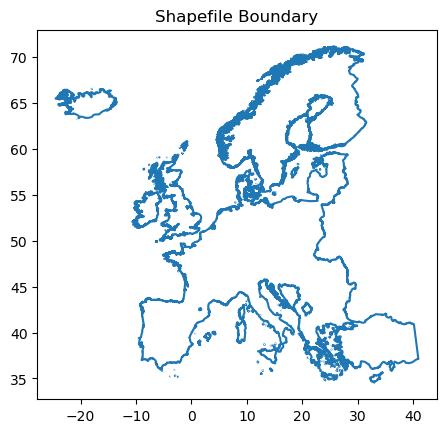

Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326
Raster CRS: EPSG:4326, Shapefile CRS: EPSG:4326


In [13]:
# Define the year range for exposure scenarios
year_range = range(2010, 2101, 10)

# Read the shapefile with GeoPandas
study_area = gpd.read_file(f"{DATADIR}/study_area_mask.shp")

# Debug: Plot shapefile
study_area.boundary.plot()
plt.title("Shapefile Boundary")
plt.show()

for year in year_range:
    input_file_path = f"{DATADIR}/ssp5_total_{year}.tif"  # Original data
    output_file_path = f"{DATADIR}/EU_SSP5_{year}_masked.tif"  # Output data

    with rasterio.open(input_file_path) as src:
        # Debug: Print CRS of raster and shapefile
        print(f"Raster CRS: {src.crs}, Shapefile CRS: {study_area.crs}")

        # Check CRS and reproject if necessary
        if src.crs != study_area.crs:
            print(f"Warning: CRS does not match for year {year}. Reprojecting...")
            study_area = study_area.to_crs(src.crs)

        shapes = study_area.geometry.values

        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open(output_file_path, "w", **out_meta) as dest:
        dest.write(out_image)


To understand the data, we estimate the population for each scenario by year in the study area to then compare it with the population potentially affected by heatwaves. Using population data from the Harvard Dataverse, we observe steady growth from 590 million in 2010 to over 812 million by 2080. This growth highlights the increasing number of individuals exposed to the rising frequency and intensity of heatwaves, helping us design better climate adaptation strategies.

In [14]:
# Dictionary to store the total population for each year
total_population_per_year = {}

# Iterate over each year SSP
for year in year_range:
    output_file_path = f"{DATADIR}/EU_SSP5_{year}_masked.tif" # Output data
    with rasterio.open(output_file_path) as src:
        out_image = src.read(1) # Read the first band of the raster
        
        # Get the NoData value from the raster metadata if it exists
        nodata_value = src.nodatavals[0]
        
        # Create a mask for valid data (this will exclude NoData values and other special values like inf or -inf)
        mask = np.isfinite(out_image) & (out_image != nodata_value)
        
        # Sum the pixel values to get the total population for the year
        total_population = np.sum(out_image[mask])
        total_population_per_year[year] = int(total_population)

# Print the total population for each year
for year, population in total_population_per_year.items():
    formatted_population = "{:,}".format(population)
    print(f"Year: {year}, Total Population: {formatted_population}")

Year: 2010, Total Population: 590,766,464
Year: 2020, Total Population: 621,456,704
Year: 2030, Total Population: 655,950,272
Year: 2040, Total Population: 690,989,760
Year: 2050, Total Population: 727,466,560
Year: 2060, Total Population: 762,996,096
Year: 2070, Total Population: 791,591,296
Year: 2080, Total Population: 812,275,904
Year: 2090, Total Population: 823,985,408
Year: 2100, Total Population: 828,090,560


## Estimating the impact for the RCP/SSP5 under study 2020-2080 every ten years

By running the impact assessment in 10-year intervals between 2020 and 2080, you will be able to identify regions most vulnerable to future heatwaves. This approach allows you to estimate how population growth or migration might influence vulnerability over time. Furthermore, analyzing these intervals helps you understand how climate scenarios, such as RCP 8.5 and SSP5, could impact long-term adaptation strategies. The results provide valuable insights into the potential risks posed by increasing heatwave intensity and frequency, helping guide decisions related to climate adaptation and risk mitigation.

>**Important:** As in the second tutorial, "Warm-Up", we use here a dummy function; this function allows for the analysis of the relationship between population and heatwave days. It calculates the percentage of the total population, which is the sum of the populations of Europe that could be affected by heatwave days. The function models heat wave impact linearly, assuming each day's exposure contributes equally to total impact, without considering adaptation or diminishing effects. Therefore, if an individual experiences one heat wave day, their impact score is 1; if they experience two days, their impact score doubles to 2, and so forth. This linear scaling suggests that the impact of each additional day of heat wave exposure is additive and does not diminish over time. It simplifies calculations but may not fully capture real-world complexities of how individuals are affected by consecutive days of heat waves, overlooking potential acclimatisation or varying susceptibility.

>**Important:** In this exercise, we will demonstrate how to save data from an impact object as a NetCDF file, which can then be used for instance in GIS tools. The data from both eai_exp and imp_mat can be saved as a NetCDF file. However, it's important to note that saving the entire impact matrix for each decade might take a considerable amount of time, potentially several minutes. If you prefer not to save the impact matrix, set include_imp_mat=False.

>**Tip:** If you only want to see the content of a hazard, exposure or impact you can use **print(dir(hazard))**

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Important: The dummy function and the uncertainty parameters addedd in this documentation allows for the analysis of the relationship between population and heatwave days. This function and parameters serves as a demonstration only; you should define your own functions according to your specific field of study. </div>

In [15]:
# Remember to call the libraries you need, you can find more detail of this step in Warm_Up documentation
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime
import os
import tempfile
from scipy.sparse import csr_matrix
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.entity import Exposures
from climada.entity import Entity
from climada.engine import Impact
from climada.engine import ImpactCalc
import rasterio
from rasterio.transform import from_origin
from utilities import ImpactWriteGeoTIFF, ImpactReaderGeoTIFF
from utilities import save_impact_data_to_NetCDF
from datetime import datetime, timedelta

def linear_mdd(intensity, impact_per_day):
      return intensity * impact_per_day

# Define the impact per day value
impact_per_day = 1  # Example impact value per day

# Assume the maximum number of summer days
max_heatwave_days = 92 # Respond to the summer days in normal meterological year


# Define the impact function
if_set = ImpactFuncSet()
if_heatwave = ImpactFunc()
if_heatwave.haz_type = 'Heat_waves_days'
if_heatwave.id = 1
if_heatwave.name = 'Heat wave impact function'
if_heatwave.intensity_unit = 'days'
if_heatwave.intensity = np.arange(0, 366, 1) # Assuming the maximum number of heat wave days in the studied period (1985-2085) is 84 (see "Explore hazard data")
if_heatwave.mdd = np.linspace(0, 1, 366) # Linearly increasing mean damage degree from 0 to 1
if_heatwave.paa = np.ones(366) # Assuming 100% of assets are affected for any heat wave days
if_set.append(if_heatwave)

# Define your scenarios
scenarios = [
    { "ssp": "SSP5", "rcp": "rcp85"},
    # Add more scenarios as needed
]

# Initialize an empty dictionary to store annual impacts
annual_impacts_dict = {}

# Define your years
years = range(2010, 2081, 10) 



# Updated scenario loop
for scenario in scenarios:
    impacts = []
    num_events = len(years)
    assert len(years) == num_events, "Number of years must match the number of events."

    for year, event_idx in zip(years, range(num_events)):
        # Filter the dataset for the specific year
        ds_filtered = ds.sel(time=ds.time.dt.year == year)

        with tempfile.NamedTemporaryFile(delete=False, suffix='.nc') as tmp:
            ds_filtered.to_netcdf(tmp.name)

        hazard = Hazard.from_xarray_raster_file(
            tmp.name,
            hazard_type='Heat_waves_days',
            intensity_unit="days",
            intensity="HWD_EU_health",  # Adjust to match your dataset
            coordinate_vars=dict(event="time", longitude="lon", latitude="lat")
        )

        os.unlink(tmp.name)

        mean_heatwave_days_per_event = np.mean(hazard.intensity.toarray(), axis=1)
        relative_frequencies = mean_heatwave_days_per_event / np.sum(mean_heatwave_days_per_event)
        hazard.frequency = relative_frequencies
        exposure_file = f"{DATADIR}/EU_SSP5_{year}_masked.tif"   
        exposure = Exposures.from_raster(exposure_file)
        exposure.value_unit = "Population"
        exposure.assign_centroids(hazard)

        hazard_type = 'Heat_waves_days'
        haz_id = if_set.get_ids()[hazard_type][0]
        exposure.gdf['impf_' + hazard_type] = haz_id

        entity = Entity()
        entity.exposures = exposure
        entity.impact_funcs = if_set

        impact = ImpactCalc(entity.exposures, entity.impact_funcs, hazard).impact(save_mat=True)

        # Use the first function to save NetCDF
        save_impact_data_to_NetCDF(
            impact_object=impact,
            filename=f'{DATADIR}/impact_data_{scenario["ssp"]}_{scenario["rcp"]}_{year}.nc',
            include_eai_exp=True,
            include_imp_mat=True,
            log_scale_imp=False,
            log_scale_eai=False
        )

        # Save GeoTIFF (optional)
        visualizer = ImpactWriteGeoTIFF(impact)
        filename = f'{DATADIR}/impact_data_{scenario["ssp"]}_{scenario["rcp"]}_{year}.tif'
        visualizer.write_to_geotiff(filename)

        annual_impacts = impact.impact_per_year()
        for year, impact_value in annual_impacts.items():
            print(f"Year: {year}, Impact: {impact_value}")
            annual_impacts_dict[year] = impact_value


/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


2025-04-04 08:26:49,400 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2734312 coordinates.
2025-04-04 08:27:36,158 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2734312 coordinates.
Data saved to NetCDF file at /Users/daraya/Documents/test_data/impact_data_SSP5_rcp85_2010.nc
Year: 2010, Impact: 10118149.375474654
2025-04-04 08:30:23,200 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2734312 coordinates.
2025-04-04 08:31:14,470 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2734312 coordinates.
Data saved to NetCDF file at /Users/daraya/Documents/test_data/impact_data_SSP5_rcp85_2020.nc
Year: 2020, Impact: 13548815.799260076
2025-04-04 08:34:05,848 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2734312 coordinates.
2025-04-04 08:34:55,190 - climada.util.

### Explore impact scenarios

Bellow, we visualize the progression of heatwave impacts on the population from 2010 to 2100. The x-axis represents the years, while the y-axis shows the total impacted population in millions.

The graph exhibits a clear upward trend in the number of people affected by heatwaves. In 2010, the impact was relatively low, starting with around 18 million people exposed to heatwaves. However, as time progresses, this number steadily increases, reaching over 100 million by 2100. This linear progression demonstrates how heatwave intensity and frequency, coupled with population growth, result in a continuously growing number of people being affected by extreme heat events.

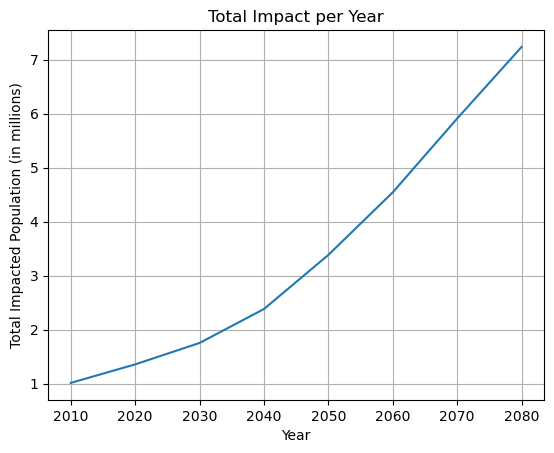

In [16]:
# Plotting the annual impacts in a separate cell

unique_years = np.array(list(annual_impacts_dict.keys()))
annual_impact_values = np.array(list(annual_impacts_dict.values())) / 10000000  # Convert to thousands

plt.plot(unique_years, annual_impact_values)
plt.xlabel('Year')
plt.ylabel('Total Impacted Population (in millions)') 
plt.title('Total Impact per Year')
plt.grid(True)
plt.show()

### Population Affected per Year: Analysis and Discussion

The data presented here outlines the total number of people affected by heatwaves in the study area for each decade, starting from 2010 and projecting through to 2080. The values are derived from the heatwave impact assessment, with the affected population steadily increasing over time.

This progression highlights a significant increase in the number of people impacted by heatwaves as time advances. From 2010 to 2080, the population affected by heatwaves grew more than sevenfold, reflecting the worsening climate conditions under the RCP 8.5 scenario. The growth is not linear but accelerates as the century progresses, particularly from 2050 onwards. 

This surge is driven by both the intensification of heatwave events and the growing population in regions vulnerable to heat stress. The data emphasises how heatwave risks will increasingly affect millions of people, indicating the severity of future climate impacts on human populations, particularly in highly exposed areas. We will explore more about the components of the vulnerability calculation and how they drive the final vulnerability levels in the subsequent tutorial **"Uncertainty and Sensitivity 04"**.

In [17]:
# Create a list to store the population affected for each year
population_affected_per_year = []

# Populate the list from the dictionary
for year in sorted(annual_impacts_dict.keys()):
    population_affected_per_year.append(int(annual_impacts_dict[year]))  # Convert to integer to remove decimals

# Print the list
print("Population affected per year:")
for year, pop_affected in zip(sorted(annual_impacts_dict.keys()), population_affected_per_year):
    formatted_pop_affected = "{:,}".format(pop_affected)  
    print(f"Year: {year}, Population affected: {formatted_pop_affected}")

Population affected per year:
Year: 2010, Population affected: 10,118,149
Year: 2020, Population affected: 13,548,815
Year: 2030, Population affected: 17,516,694
Year: 2040, Population affected: 23,800,654
Year: 2050, Population affected: 33,822,741
Year: 2060, Population affected: 45,416,779
Year: 2070, Population affected: 59,084,790
Year: 2080, Population affected: 72,342,291


From 2010 to 2080, the number of heatwave days per year escalates from just under three days to almost seventeen days, representing a more than fivefold increase. This significant rise underscores the escalating severity and frequency of heatwave events, a prominent characteristic of the RCP 8.5 high-emission scenario. The sharp increase between 2050 and 2080 indicates that, as global temperatures continue to rise, heatwave events will become both more frequent and prolonged, with severe implications for health, infrastructure, and economic stability.

The average heatwave intensity numbers reflect a clear trend of worsening climate conditions, consistent with projections under high-emission scenarios. By the end of the century, extreme heat events could become a regular, multi-week occurrence in many regions, significantly increasing stress on public health systems, energy grids, and food production.

In [18]:
# Define the range of years
years = range(2010, 2081, 10)

# Load the Hazard object (assuming DATADIR and file path are correctly set)
hazard = Hazard.from_xarray_raster_file(f'{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc', hazard_type='Heat_waves_days', intensity_unit="days", 
                                        intensity="HWD_EU_health", coordinate_vars=dict(event="time", longitude="lon", latitude="lat"))

# Convert event dates to Pandas Timestamps for easier year extraction
event_years = [pd.to_datetime(date).year for date in hazard.event_name]

# Initialize a dictionary to store average intensity per event for specified years
average_intensity_years = {}

# Iterate over each event and its corresponding year
for event_id, event_year, intensity in zip(hazard.event_id, event_years, hazard.intensity):
    # Check if the event year is within our years of interest
    if event_year in years:
        # Calculate the average intensity for the event
        avg_intensity = intensity.mean()
        # Store the result in the dictionary
        average_intensity_years[event_year] = average_intensity_years.get(event_year, 0) + avg_intensity

# Normalize the values by the number of events in each year (if needed)
for year in average_intensity_years:
    count_events = event_years.count(year)
    if count_events > 0:
        average_intensity_years[year] /= count_events

# Print the results
for year, avg_intensity in average_intensity_years.items():
    print(f"Year: {year}, Average Heat Wave Intensity: {avg_intensity:.2f}")

Year: 2010, Average Heat Wave Intensity: 2.98
Year: 2020, Average Heat Wave Intensity: 3.89
Year: 2030, Average Heat Wave Intensity: 4.94
Year: 2040, Average Heat Wave Intensity: 6.45
Year: 2050, Average Heat Wave Intensity: 8.54
Year: 2060, Average Heat Wave Intensity: 11.05
Year: 2070, Average Heat Wave Intensity: 13.89
Year: 2080, Average Heat Wave Intensity: 16.83


Earlier, we calculated the total population for each year under study and the total number of people impacted by heatwaves. By comparing these two datasets, we now have a more complete picture of the broader risk to populations. While the total population grows steadily, the percentage of the population affected by heatwaves increases at a faster rate, indicating that heatwave risk is outpacing population growth.

This shows that the heatwave risk intensifies not only because there are more people in the world but also because heatwaves themselves become more severe and frequent. This highlights the pressing need to prioritize climate adaptation strategies to protect larger segments of the population as heatwave risks continue to escalate over time.

In [19]:
# Dictionary to store the percentage of the population affected for each year
percentage_affected_per_year = {}

# Iterate over each year to calculate the percentage
for year in sorted(annual_impacts_dict.keys()):
    total_population = total_population_per_year[year]
    population_affected = annual_impacts_dict[year]
    
    percentage_affected = (population_affected / total_population) * 100
    percentage_affected_per_year[year] = round(percentage_affected, 2)  # Rounding to 2 decimal places

# Print the percentage of population affected for each year
print("Percentage of population affected per year:")
for year, percentage in percentage_affected_per_year.items():
    print(f"Year: {year}, Percentage affected: {percentage}%")


Percentage of population affected per year:
Year: 2010, Percentage affected: 1.71%
Year: 2020, Percentage affected: 2.18%
Year: 2030, Percentage affected: 2.67%
Year: 2040, Percentage affected: 3.44%
Year: 2050, Percentage affected: 4.65%
Year: 2060, Percentage affected: 5.95%
Year: 2070, Percentage affected: 7.46%
Year: 2080, Percentage affected: 8.91%


### Visualization of the results 

We can also access and spatially deploy the eight files created for eai_exposure between 2010 and 2080. Below, you can see an example for the year 2010 of eai_exposure presented both as a NetCDF file and as a TIFF file. In both cases, the data is displayed on a logarithmic scale.

>**Important:** Spatially explicit deployment of the exposure offers several advantages, to mention some of the most relevant at this stage:

>- Immediate Identification of Hotspots: The logarithmic scale allows straightforward identification of hotspot areas with high exposure levels.

>- Spatial Context: The visual representation provides a spatial context to the exposure data, making it easier to understand where vulnerabilities are located. This is particularly useful for identifying how exposure levels relate to geographical features like rivers, mountains, or urban centers.

>- Data Validation: The map also serves as a tool for quickly identifying anomalies or errors in the data, such as unexpected spikes in exposure levels.

By combining these elements, we can gain a comprehensive understanding of eai_exposure across the study area, aiding in both data validation and policy planning.

In [20]:
# Explore the properties of one of the outputs 
## Deployed the eai_exposure in TIFF format for 2010
filename = f'{DATADIR}/impact_data_SSP5_rcp85_2010.nc'
ds = xr.open_dataset(filename)
ds

<xarray.Dataset> Size: 415MB
Dimensions:    (latitude: 4396, longitude: 7862, time: 1)
Coordinates:
  * latitude   (latitude) float64 35kB 34.56 34.57 34.58 ... 71.17 71.18 71.19
  * longitude  (longitude) float64 63kB -24.53 -24.52 -24.51 ... 40.97 40.98
  * time       (time) <U10 40B '01-01-2010'
Data variables:
    eai_exp    (latitude, longitude) float64 276MB ...
    imp_mat    (time, latitude, longitude) float32 138MB ...
Attributes:
    crs:      EPSG:4326

The two plots shown represent the spatial outputs from the heatwave impact assessment. These files can be exported and opened in any GIS software (such as QGIS or ArcGIS), allowing further geographic analysis or integration into other spatial datasets. By reading the data in GIS, you can overlay additional layers like infrastructure or health facilities, enabling more comprehensive climate risk assessments and adaptation planning:

- The first plot visualizes the annual exposure (eai_exp), which indicates the number of people potentially exposed to heatwaves within the study area during a given year. The color intensity in the map shows regions where populations are most at risk, with darker shades corresponding to higher exposure. This data helps identify areas that are likely to experience significant heatwave impacts based on population density and hazard intensity.

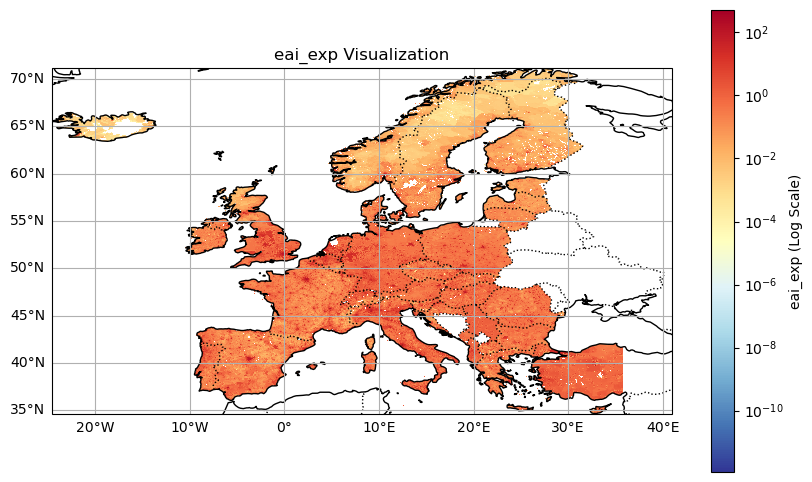

In [21]:
from utilities import ImpactReaderNetCDF_Scenario
filename = f'{DATADIR}/impact_data_SSP5_rcp85_2010.nc'  
reader = ImpactReaderNetCDF_Scenario(filename)
reader.read_netcdf()
reader.visualize_eai_exp(scale='log')  # Visualize eai_exp with logarithmic scale

- The second plot shows the impact matrix (imp_mat), which illustrates the estimated population impact of heatwaves across the region. The impact matrix allows the user to store data from all studied years and display the one of interest as needed. It combines the exposure data with vulnerability and impact functions to provide an overview of the expected losses or disruptions due to heatwaves. Similar to the first plot, the color scale indicates regions of higher impact, offering a clear visual representation of areas that may require targeted climate adaptation measures.

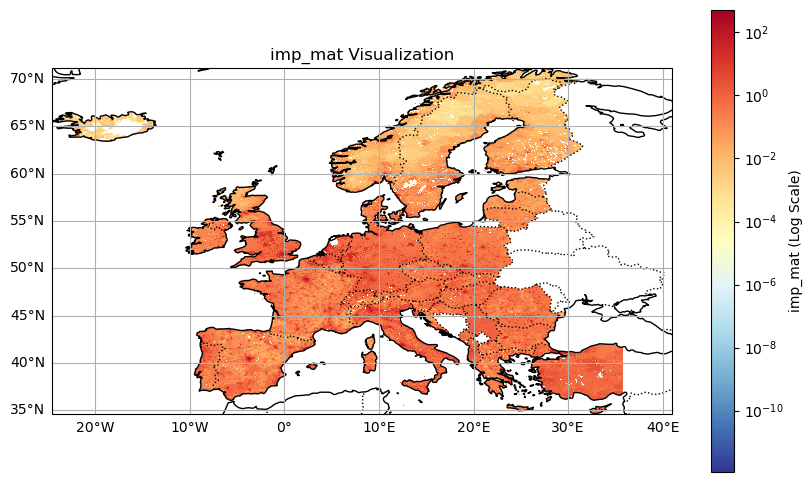

In [22]:
reader = ImpactReaderNetCDF_Scenario(filename)
reader.read_netcdf()
reader.visualize_imp_mat(scale='log')  # Visualize imp_mat with logarithmic scale

It is also possible to deploy and export these results as a TIFF object, which allows for further geographic analysis in any GIS software such as QGIS or ArcGIS. In the figure shown, the output for expected annual impact is saved as a `.tif` file, ensuring compatibility with spatial analysis tools. The TIFF format is particularly useful because it retains geospatial information, enabling users to overlay the data with other layers, such as infrastructure or land use maps.

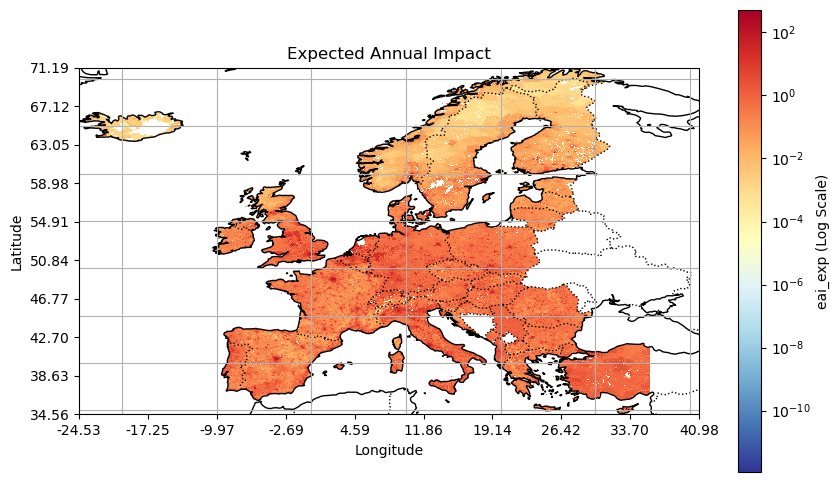

In [23]:
# Deployed the eai_exposure in TIFF format for 2010
filename = f'{DATADIR}/impact_data_SSP5_rcp85_2010.tif'
reader = ImpactReaderGeoTIFF(filename)
reader.plot_geotiff(scale='log')

The following figure shows a side-by-side comparison of the population potentially affected by heatwaves in various years, from 2010 through 2080, under the RCP 8.5 scenario. Each panel represents a different decade, allowing us to observe the spatial progression of heatwave impacts across the study area over time.

The maps indicate that the population exposed to heatwaves increases consistently each decade. In 2010, the affected population was relatively sparse and concentrated in certain regions. However, by 2080, the affected areas have expanded dramatically, with nearly all Europe showing substantial populations exposed to heatwaves. The heatmaps also show a geographical pattern of vulnerability. Northern and Western Europe, which initially exhibit less heatwave exposure, become significantly more impacted as time progresses. Southern Europe, already vulnerable in 2010, experienced the most drastic increases in population exposure by 2080. This spatial distribution helps highlight which regions might need more targeted adaptation strategies based on their projected vulnerability to future heatwaves.

This multi-year comparison is highly effective in communicating the urgency of climate change to stakeholders, policymakers, and the public. The stark differences between 2010 and 2080 emphasize how quickly the situation will worsen if no action is taken, making the case for climate adaptation strategies more compelling.


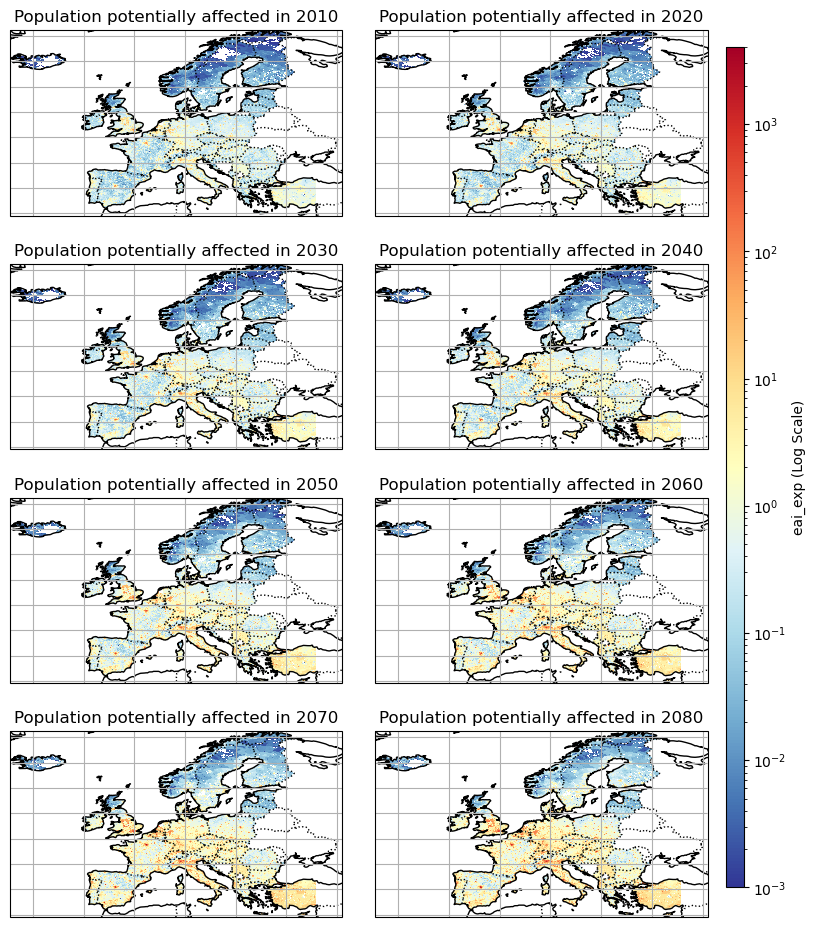

In [24]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely")

# Create a copy of the colormap and set values less than vmin to white
cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
cmap.set_under("white")

# Define the year range and other parameters
year_range = range(2010, 2081, 10)
file_prefix = "impact_data_SSP5_rcp85_"

# Initialize plot
fig, axs = plt.subplots(4, 2, figsize=(9, 12), subplot_kw={"projection": ccrs.PlateCarree()})

# Flatten the axis array for easy indexing
axs = axs.flatten()

# Define color scale limits 
vmin, vmax = 0.001, 4000  

# Logarithmic normalization
norm = LogNorm(vmin=vmin, vmax=vmax)

for i, year in enumerate(year_range):
    file_path = f"{DATADIR}/{file_prefix}{year}.tif"

    # Read the GeoTIFF file
    with rasterio.open(file_path) as src:
        # Read the first band (assuming your data is in the first band)
        data = src.read(1)
           
        # Get the bounds and transform
        transform = src.transform
        extent = [transform[2], transform[2] + transform[0]*src.width, transform[5] + transform[4]*src.height, transform[5]]

        # Generate meshgrid for pcolormesh
        x = np.linspace(extent[0], extent[1], data.shape[1])
        y = np.linspace(extent[2], extent[3], data.shape[0])
        
        # Reverse the data array along the y-axis to match the reversed y array
        data = np.flipud(data)

        X, Y = np.meshgrid(x, y)

        # Plot the data
        ax = axs[i]
        im = ax.pcolormesh(X, Y, data, cmap=cmap, norm=norm, shading="auto")
        ax.set_title(f"Population potentially affected in {year}")
        
        ax.coastlines()
        ax.gridlines()
        ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("eai_exp (Log Scale)")

# Reduce space between subplots
plt.subplots_adjust(hspace=0.05, wspace=0.1)

plt.show()

# Resume

By the end of this tutorial, a solid understanding of how to work with scenario data, a key component in vulnerability assessments, is achieved. The focus was on integrating climate data from the Copernicus Climate Data Store (CDS) with CLIMADA to assess heatwave impacts under the RCP 8.5 scenario. Key steps included accessing, downloading, and processing scenario data, along with setting up hazard, exposure, and vulnerability inputs to quantify the socio-economic impacts of climate risks over time.

A significant part of the tutorial involved data visualization and analysis, essential for understanding how climate risks evolve. Heatwave impact maps and exposure models were generated to conduct a temporal vulnerability analysis, showing how heatwave impacts change from 2010 to 2080. This provided a clear view of how climate hazards intensify and spread across different regions, especially in areas with growing heat stress.

Additionally, several visualization options were introduced to help identify vulnerable regions and assess the long-term effects of climate change. Transferring annual exposure and impact matrix data to GIS software was also demonstrated. As the analysis shows, exposure increases significantly over time, highlighting the importance of adaptation measures. These visual tools support understanding and communicating the growing risks to stakeholders and decision-makers.

Overall, the tutorial provided practical experience in handling scenario data and conducting climate risk assessments, focusing on using scenario-based analysis and visual tools to understand better and communicate the increasing risks of climate change.